In [23]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import cv2
import matplotlib.pyplot as plt
from lib.utils.demo_utils import video_to_images
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import glob
from torchvision.io import read_image
import torch.nn.functional as F
from multi_person_tracker import MPT
import os
import os.path as osp
from lib.data_utils.img_utils import get_single_image_crop_demo
from tqdm import tqdm

### Convert Silhouette Video to Images

In [2]:
# for video_file in glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/video/*'):
#     img_folder = '/home/epinyoan/dataset/casia-b/dataset_b/all/images/'+video_file.split('/')[-1].split('.')[0]+'/'
#     video_to_images(video_file, img_folder=img_folder)

### Crop

In [3]:
subject_id, condition, walk_id, angle = '005-nm-01-144'.split('-')
image_folder = '/home/epinyoan/dataset/casia-b/dataset_b/all/images/'+subject_id+'-'+condition+'-'+walk_id+'-'+angle
s_folder = '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/'+subject_id+'/'+condition+'-'+walk_id+'/'+angle #+'/'+subject_id+'-'+condition+'-'+walk_id+'-'+angle+'-'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mot = MPT(
    device=device,
    batch_size=12,
    display=False,
    detector_type='yolo',
    output_format='dict',
    yolo_img_size=416,
)
tracking_results = mot(image_folder)

# remove tracklets if num_frames is less than MIN_NUM_FRAMES
for person_id in list(tracking_results.keys()):
    if tracking_results[person_id]['frames'].shape[0] < 25:
        del tracking_results[person_id]
        
person_id = list(tracking_results.keys())[0]
bboxes = tracking_results[person_id]['bbox']
frames = tracking_results[person_id]['frames']

Running Multi-Person-Tracker


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.25it/s]

Finished. Detection + Tracking FPS 59.35


In [5]:
def find_frame_idx(f, frames):
    exact_frame = np.where(frames >= f)
    if len(exact_frame[0]) > 0:
        return exact_frame[0][0]
    else:
        return np.where(frames < f)[0][-1]

In [6]:
def rescale_to_1(val):
    return (val - val.min())/(val.max()-val.min())

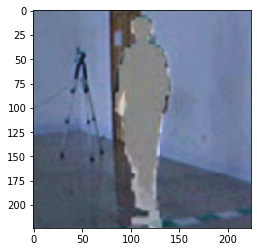

In [9]:
s_img_paths = glob.glob(s_folder+'/*')
silhuette_imgs = []
norm_imgs = []
final_bboxes = []
final_frames = []
for i, s_img_path in enumerate(sorted(s_img_paths)):
    # 1. video
    s_img = cv2.imread(s_img_path)
    f = int(s_img_path.split('/')[-1].split('.')[0].split('-')[-1])
    idx = find_frame_idx(f, frames)
    s_norm_img, s_raw_img, s_kp_2d = get_single_image_crop_demo(
            s_img,
            bboxes[idx],
            kp_2d=None,
            scale=1.1,
            crop_size=64)
    silhuette_imgs.append(s_raw_img[:,:,0])
    
    # 2. silhouette
    image_file_name = image_folder+'/'+str(frames[idx]).zfill(6)+'.png'
    img = cv2.cvtColor(cv2.imread(image_file_name), cv2.COLOR_BGR2RGB)
    norm_img, raw_img, kp_2d = get_single_image_crop_demo(
            img,
            bboxes[idx],
            kp_2d=None,
            scale=1.1,
            crop_size=224)
    norm_imgs.append(norm_img.detach().cpu().numpy())
    
    # 3. preprocessed bboxes & frames
    final_bboxes.append(bboxes[idx])
    final_frames.append(f)
#     if i == 50:
#         break
    
silhuette_imgs = np.array(silhuette_imgs)
norm_imgs = np.array(norm_imgs)
final_bboxes = np.array(final_bboxes)
final_frames = np.array(final_frames)

s_raw_img = cv2.resize(s_raw_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
img = rescale_to_1(raw_img) + .5*rescale_to_1(s_raw_img)
img = rescale_to_1(img)
plt.imshow(img)

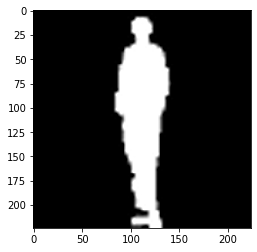

In [11]:
ss = s_raw_img[:,:,0]
ss = np.expand_dims(ss, axis=2)
ss = np.repeat(ss, 3, axis=2)
plt.imshow(ss)

In [7]:
file_name = '/home/epinyoan/dataset/casia-b/dataset_b/all/crop/'+subject_id+'-'+condition+'-'+walk_id+'-'+angle+'.npz'
np.savez(file_name, silhuette_imgs=silhuette_imgs, norm_imgs=norm_imgs, bboxes=bboxes, frames=frames)

In [50]:
file_name = '/home/epinyoan/dataset/casia-b/dataset_b/all/crop/077-nm-03-018.npz'
data = np.load(file_name, allow_pickle=True)
data['silhuette_imgs'].shape, data['norm_imgs'].shape, data['bboxes'].shape, data['frames'].shape

((144, 64, 64), (144, 3, 224, 224), (144, 4), (144,))

### Check Continuous Frames for Silhouette
###### The most broken walks
005-bg-01-144-154

In [10]:
# real_img = cv2.imread(image_folder+'/000100.png')
def get_seq_from_path(path):
    return int(path.split('/')[-1].split('.')[0].split('-')[-1])
def get_missing_silhoutte():
    silhouette_paths = []
    missing_frames = {}
    for folder_person in glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/*'):
        person = int(folder_person.split('/')[-1])
        for folder_condition in glob.glob(folder_person+'/*'):
            condition = folder_condition.split('/')[-1]
            for folder_angle in glob.glob(folder_condition+'/*'):
                img_paths = sorted(glob.glob(folder_angle+'/*'))
                for i, img_path in enumerate(img_paths):
                    seq = get_seq_from_path(img_path)
                    if i > 0:
                        prev = get_seq_from_path(img_paths[i-1])
                        if seq != prev+1:
                            if img_path not in missing_frames.keys():
                                missing_frames[img_path] = []
                            missing_frames[img_path].append([prev,seq, len(img_paths)])
#                             print(img_path)
#                             print(seq, prev)
#                             print([get_seq_from_path(a) for a in img_paths])
    return missing_frames
missing_frames = get_missing_silhoutte()

In [11]:
for seq in missing_frames:
    length = missing_frames[seq][0][1] - missing_frames[seq][0][0]
    if length>30:
        print(seq, length, missing_frames[seq][0]) #.split('/')[-1]

/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/nm-03/162/013-nm-03-162-045.png 32 [13, 45, 103]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/cl-01/162/013-cl-01-162-053.png 36 [17, 53, 102]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/bg-02/162/013-bg-02-162-050.png 33 [17, 50, 112]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/nm-04/162/013-nm-04-162-046.png 34 [12, 46, 107]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/cl-02/162/013-cl-02-162-072.png 32 [40, 72, 138]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/nm-01/162/013-nm-01-162-061.png 34 [27, 61, 109]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/bg-01/162/013-bg-01-162-066.png 34 [32, 66, 123]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/nm-05/162/013-nm-05-162-052.png 35 [17, 52, 111]
/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/013/nm-02/162/013-nm-02-162-064.png 40 [24, 64, 115]
/home/epin

### Silhouette Different Size [320 & 300]

###### Load Silhouette Images

In [63]:
# real_img = cv2.imread(image_folder+'/000100.png')
silhouette_paths = []
for folder_person in glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/*'):
    person = int(folder_person.split('/')[-1])
    for folder_condition in glob.glob(folder_person+'/*'):
        condition = folder_condition.split('/')[-1]
        for folder_angle in glob.glob(folder_condition+'/*'):
            angle = folder_angle.split('/')[-1]
            for file_image in glob.glob(folder_angle+'/*'):
                silhouette_paths.append(file_image)
# person-condition-angle-frame
silhouette_paths

['/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-093.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-091.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-124.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-051.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-105.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-126.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-018.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-102.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-006.png',
 '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/077/nm-03/018/077-nm-03-018-065.png',
 '/home/epinyoan/dataset/casia

In [64]:
p320 = []
p300 = []
for im_path in silhouette_paths:
    image = read_image(im_path)
    if image.shape == torch.Size([1, 240, 320]):
        p320.append(im_path)
    elif image.shape == torch.Size([1, 240, 300]):
        p300.append(im_path)
    else:
        print('---')
len(silhouette_paths), len(p300), len(p320)

(1118373, 36435, 1081938)

In [6]:
silhouette_paths_320 = np.array(p320)
np.save('/home/epinyoan/dataset/casia-b/dataset_b/all/silhouette_paths_320.npy', silhouette_paths_320)

### Overlay Silhouette

In [2]:
def overlay(raw, silh):
    image = raw + silh/2
    image = torch.clip(image, max=255)
    plt.imshow(torch.permute(image/255, (1,2, 0)))

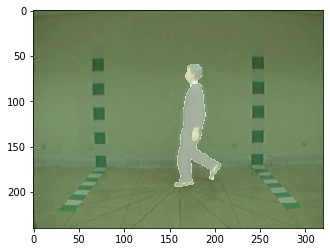

In [17]:
subject_id, condition, walk_id, angle, frame = '004-nm-01-090-095'.split('-')
silhouette_path = '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouettes/'+subject_id+'/'+condition+'-'+walk_id+'/'+angle+'/'+subject_id+'-'+condition+'-'+walk_id+'-'+angle+'-'+frame+'.png'
im_path = '/home/epinyoan/dataset/casia-b/dataset_b/all/images/'+subject_id+'-'+condition+'-'+walk_id+'-'+angle+'/'+frame.zfill(6)+'.png'
image = read_image(im_path)

s_image = read_image(silhouette_path)
# s_image = F.pad(s_image, (0,20), "constant", 255)
overlay(image, s_image)

(<matplotlib.image.AxesImage at 0x7f751693fad0>, torch.Size([1, 240, 340]))

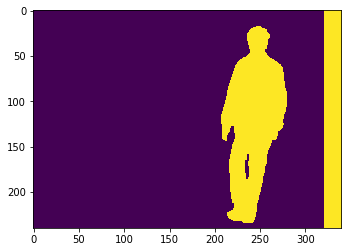

In [35]:
image = read_image(silhouette_path)
image = F.pad(image, (0,20), "constant", 255)
plt.imshow(image[0]), image.shape

### DataLoader

In [52]:
silhouette_paths = '/home/epinyoan/dataset/casia-b/dataset_b/all/silhouette_paths_320.npy'
silhouette_paths = np.load(silhouette_paths)

In [9]:
class VideoSilhouetteDataset(Dataset):
    def __init__(self, silhouette_paths, transform=None, target_transform=None):
        self.silhouette_paths = silhouette_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.silhouette_paths)

    def __getitem__(self, idx):
        s_image = read_image(self.silhouette_paths[idx])
        file = self.silhouette_paths[idx].split('/')[-1].split('.')[0].split('-')
        raw_path = '/home/epinyoan/dataset/casia-b/dataset_b/all/images/'+'-'.join(file[:4])+'/'+file[4].zfill(6)+'.png'
        raw_image = read_image(raw_path)
        return raw_image, s_image

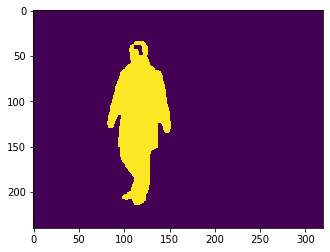

In [63]:
vs_dataset = VideoSilhouetteDataset(silhouette_paths)
train_loader = DataLoader(vs_dataset, batch_size=64,
                                  num_workers=1, pin_memory=True, shuffle=True)
for batch_idx, (raw_image, s_image) in enumerate(train_loader):
#     plt.imshow(s_image[0,0])
    overlay(raw_image[0], s_image[0])
    break

### Save image frames instead of videos

In [35]:
file_names = glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/crop/*')
all_file_names = []
for file_name in file_names:
    subject_id = int(file_name.split('/')[-1].split('.')[0].split('-')[0])
    if int(subject_id) >= 90:
        all_file_names.append(file_name)
len(all_file_names)

3631

In [37]:
crop_image_path = '/home/epinyoan/dataset/casia-b/dataset_b/all/crop_images/'
for file_name in tqdm(glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/crop/*')):
    folder_path = crop_image_path + file_name.split('/')[-1].split('.')[0]
    os.makedirs(folder_path, exist_ok=True)
    data = np.load(file_name, allow_pickle=True)
    for i, frame in enumerate(data['frames']):
        np.savez(folder_path+'/'+str(frame), 
                         silhuette_imgs=data['silhuette_imgs'][i], 
                         norm_imgs=data['norm_imgs'][i], 
                         bboxes=data['bboxes'][i])
    break

  0%|                                                                                                                                                                                                 | 0/12984 [00:00<?, ?it/s]

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


  0%|                                                                                                                                                                                                 | 0/12984 [00:07<?, ?it/s]

114
